In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from tabulate import tabulate

### 20-VN with Identity Covariance

In [2]:
cov =  np.eye(20)
mu = np.full(shape=(20,), fill_value=0)

In [3]:
n = ss.multivariate_normal(mean=mu, cov=cov)

In [4]:
sample = n.rvs(5)

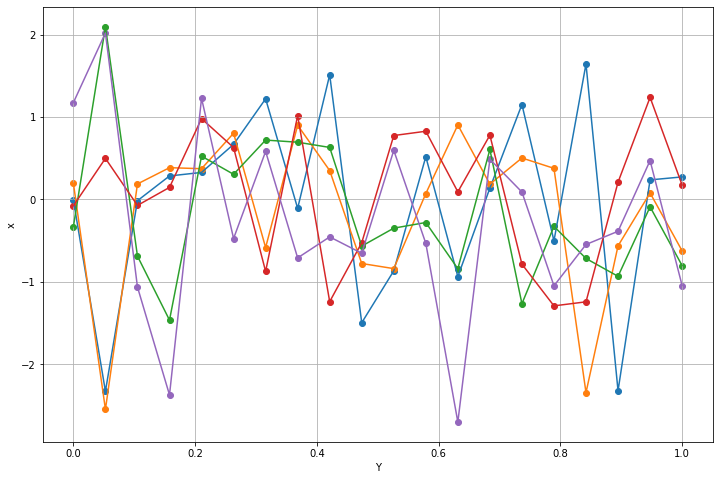

In [5]:
plt.figure(1, figsize=(12, 8))
ys = np.linspace(0, 1, 20)
for i in range(sample.shape[0]):
    plt.plot(ys, sample[i], label=i)
    plt.scatter(ys, sample[i])

plt.xlabel("Y")
plt.ylabel("x")
plt.grid()
plt.show()

## GPR

In [6]:
# Create some sample data
X = ss.uniform(loc=-2*np.pi, scale=4*np.pi).rvs(10)
X = X.reshape((-1, 1))

f = lambda x: 5*np.sin(x) + 3*np.cos(2*x)

sigma_n = 0.5

y = f(X) + ss.norm(loc=0, scale=sigma_n).rvs(X.shape)  # IID zero-mean Gaussian noise

In [7]:
print(tabulate(y))

---------
-5.70316
 1.60372
 1.47882
 2.85908
 4.53256
 4.23346
 1.95464
-0.902829
-5.45722
 2.25612
---------


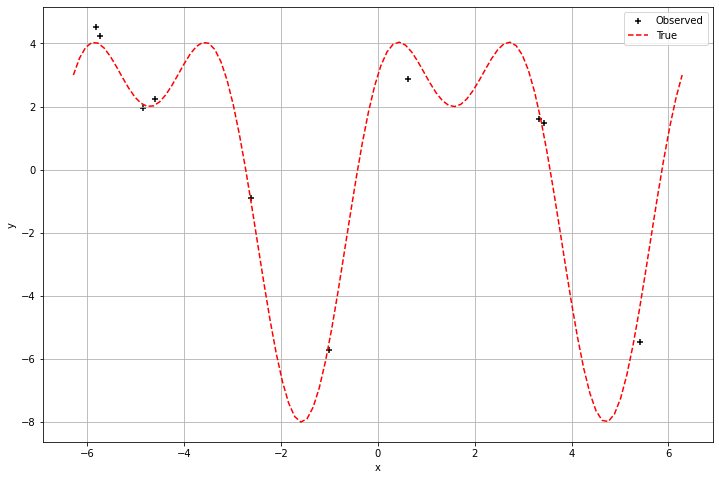

In [8]:
xs = np.linspace(-2*np.pi, 2*np.pi, 100)

plt.figure(2, figsize=(12, 8))

plt.scatter(X, y, marker="+", color="black", label="Observed")
plt.plot(xs, f(xs), 'r--', label="True")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [9]:
# Kernel function
def RBF(xi, xj, sigma_f=1, l=0.6):
    return sigma_f**2 * np.exp(-1/(2*l**2) * (xi - xj)**2)

In [10]:
# Create K
XXi, XXj = np.meshgrid(X, X, indexing="ij")

K = RBF(XXi, XXj)

In [11]:
# Check the shape of K - should be nxn
K.shape

(10, 10)

In [12]:
# K should be positive definite
print(tabulate(K))

-----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------
1            4.40557e-12  1.29575e-12  0.0257812    1.05022e-14  3.64177e-14  1.29131e-09  0.028356     1.48541e-25  1.5984e-08
4.40557e-12  1            0.986104     3.5506e-05   2.92879e-51  3.14959e-50  4.5808e-41   5.16309e-22  0.00250317   1.06927e-38
1.29575e-12  0.986104     1            1.64187e-05  2.25052e-52  2.48439e-51  4.61976e-42  9.71598e-23  0.0044044    1.15418e-39
0.0257812    3.5506e-05   1.64187e-05  1            1.01747e-25  5.38767e-25  1.01511e-18  5.3477e-07   1.39351e-14  3.76915e-17
1.05022e-14  2.92879e-51  2.25052e-52  1.01747e-25  1            0.987827     0.266921     5.96414e-07  8.58471e-77  0.127029
3.64177e-14  3.14959e-50  2.48439e-51  5.38767e-25  0.987827     1            0.340045     1.36188e-06  1.58692e-75  0.172449
1.29131e-09  4.5808e-41   4.61976e-42  1.01511e-18  0.266921     0.340045     1            0.000957322  

In [13]:
# Algo 2.1:
# L = cholesky(K + sigma**2 * I)
# alpha = L.T \ (L \ y)
# f = Ks.T @ alpha (posterior mean)
# v = L \ Ks
# V = Kss - v.T @ v (posterior covariance)

# Cholesky decomposition
L = np.linalg.cholesky(K + sigma_n**2*np.eye(*X.shape))

In [14]:
# Lower triangular 
print(tabulate(L))

-----------  ------------  ------------  ------------  -----------  -----------  -----------  -----------  ------------  --------
1.11803       0             0             0            0            0            0            0             0            0
3.94046e-12   1             0             0            0            0            0            0             0            0
1.15896e-12   0.986104      0.166127      0            0            0            0            0             0            0
0.0230594     3.5506e-05   -0.000111926   0.999734     0            0            0            0             0            0
9.39348e-15  -3.70146e-26   1.54181e-25  -2.16665e-16  1            0            0            0             0            0
3.2573e-14   -1.28353e-25   5.3464e-25   -7.51313e-16  0.987827     0.155554     0            0             0            0
1.15498e-09  -4.55116e-21   1.89574e-20  -2.66402e-11  0.266921     0.490974     0.829275     0             0            0
0.0253624

In [15]:
alpha = np.linalg.lstsq(L.T, np.linalg.lstsq(L, y, rcond=None)[0], rcond=None)[0]

In [16]:
# Predict over new Xs values
Xs = np.linspace(-2*np.pi, 2*np.pi, 100)  # n* = 100

XXs, XX = np.meshgrid(Xs, X, indexing="ij")

Ks = RBF(XXs, XX)

In [17]:
print(Ks.shape)  # Shape should be n* x n
print(alpha.shape)

(100, 10)
(10, 1)


In [18]:
Fs = np.dot(Ks, alpha)

In [19]:
v = np.linalg.lstsq(L, Ks.T, rcond=None)[0]

In [20]:
Xsi, Xsj = np.meshgrid(Xs, Xs, indexing="ij")
Kss = RBF(Xsi, Xsj)

V = Kss - np.dot(v.T, v)
V_diag = np.diag(V)  # Main diagonal is the variances

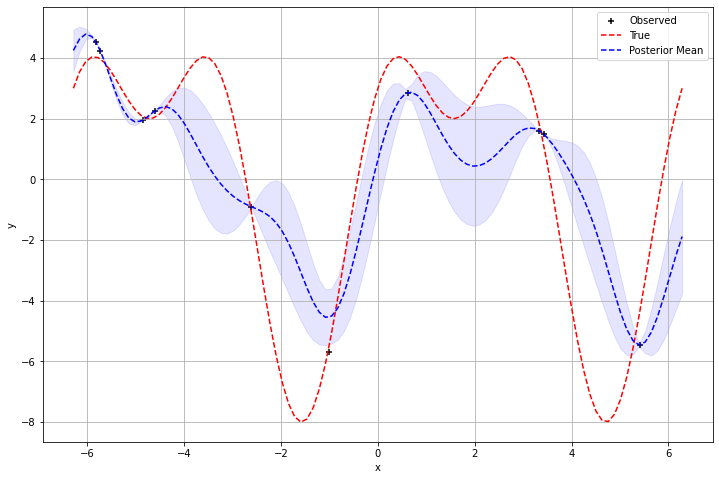

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X, y, marker="+", color="black", label="Observed")
ax.plot(Xs, f(Xs), 'r--', label="True")
ax.plot(Xs, Fs, 'b--', label="Posterior Mean")
ax.fill_between(Xs, (Fs.flatten() - 2*np.sqrt(V_diag)), (Fs.flatten() + 2*np.sqrt(V_diag)), color='b', alpha=.1)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()